<a href="https://colab.research.google.com/github/alexandrgsv/stock_prediction_models/blob/main/%22MMVB_LSTM_ub_lb_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

In [50]:
# Load the data
#data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D', header=0, usecols=['<DATE>', '<CLOSE>'], date_parser=True)
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0, 
                   usecols=['<DATE>', '<CLOSE>'], 
                   parse_dates=['<DATE>'], 
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [51]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)
#df = df.set_index('<DATE>').sort_index()



In [53]:
df.tail()

,<DATE>,<CLOSE>
5005,2023-03-23,2388.35
5006,2023-03-24,2391.53
5007,2023-03-27,2440.68
5008,2023-03-28,2442.19
5009,2023-03-29,2444.90


In [54]:
# Define the window size and the forecast horizon
window_size = 60
forecast_horizon = 30


In [55]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size-window_size:]

In [56]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))


In [57]:
# Create the training and test data using the sliding window approach
X_train = []
y_train = []
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(window_size, len(test_scaled)-forecast_horizon):
    X_test.append(test_scaled[i-window_size:i, 0])
    y_test.append(test_scaled[i:i+forecast_horizon, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [58]:
# Define the model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=forecast_horizon*2)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [59]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
99/99 [==============================] - 20s 140ms/step - loss: 0.0451 - val_loss: 0.0145
Epoch 2/100
99/99 [==============================] - 12s 124ms/step - loss: 0.0082 - val_loss: 0.0026
Epoch 3/100
99/99 [==============================] - 13s 135ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 4/100
99/99 [==============================] - 12s 125ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/100
99/99 [==============================] - 12s 124ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 6/100
99/99 [==============================] - 14s 139ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 7/100
99/99 [==============================] - 12s 124ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/100
99/99 [==============================] - 12s 125ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 9/100
99/99 [==============================] - 12s 125ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/100
99/99 [==============================] - 12s 125ms/step - loss: 0.002

In [60]:
y_test.shape

(972, 30)

In [61]:
y_train.shape

(3948,)

In [62]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

31/31 [==============================] - 2s 40ms/step


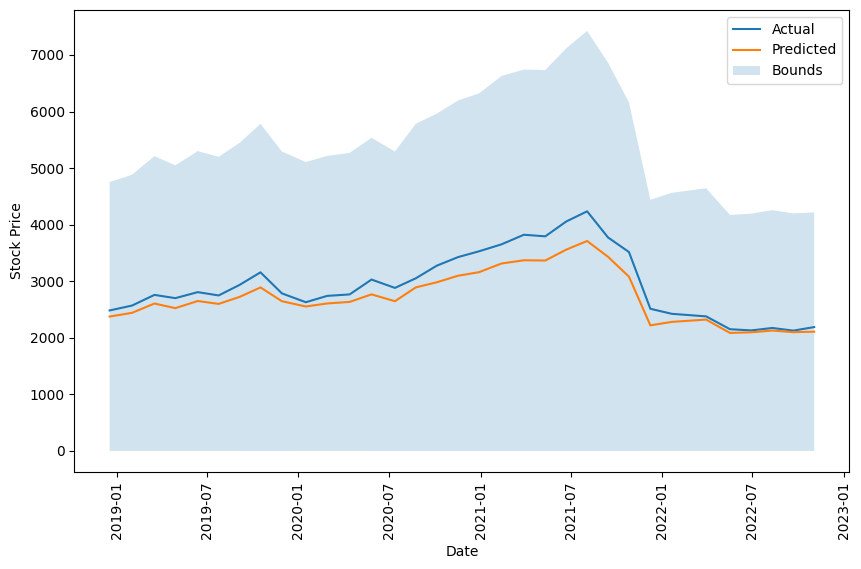

In [63]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test['<DATE>'][:-forecast_horizon-60][::forecast_horizon], y_test[:, 0][::forecast_horizon], label='Actual')
ax.plot(test['<DATE>'][:-forecast_horizon-60][::forecast_horizon], y_pred[:, 0][::forecast_horizon], label='Predicted')
ax.fill_between(test['<DATE>'][:-forecast_horizon-60][::forecast_horizon], y_pred[:, 0][::forecast_horizon]-y_pred[:, 1][::forecast_horizon], y_pred[:, 0][::forecast_horizon]+y_pred[:, 2][::forecast_horizon], alpha=0.2, label='Bounds')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.xticks(rotation=90)
plt.show()